## Linear Congruential Generators (LCGs)

Linear Congruential Generators (LCGs) are one of the oldest PRNGs and fortunately pretty simple to understand.

to get the next number in the sequence we take the previous number and:
- multiply it by some constant a
- add some other constant c to it
- take the remainder when we divide by some other constant m

$$ x_{n+1} = (a x_n + c) \mod m $$

3, 9, 27, 81, 243, 217, 139, 161, 227, 169, 251, 241, 211, 121, 107, 65, 195, 73, 219, 145, 179, 25, 75, 225, 163, 233, 187, 49, 147, 185, 43, 129, 131, 137, 155, 209, 115, 89, 11, 33, 99, 41, 123, 113, 83, 249, 235, 193, 67, 201, 91, 17, 51, 153, 203, 97, 35, 105, 59, 177, 19, 57, 171, 1, 3, 9, 27, 81, 243, 217, 139, 161, 227, 169, 251, 241, 211, 121, 107, 65, 195, 73, 219, 145, 179, 25, 75, 225, 163, 233, 187, 49, 147, 185, 43, 129, 131, 137, 155, 209


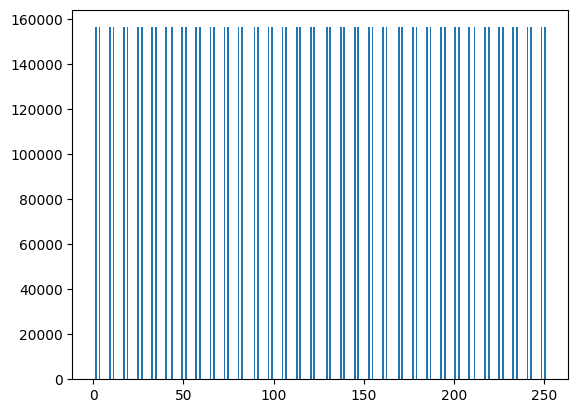

In [9]:
def lcg_lehman(seed, a = 3, c = 0, m = 2**8):
    """Lehman 1951 LCG generator"""
    while True:
        # multiply by 3 to get next value from previous
        seed = (a * seed + c) % m
        yield seed

# seed generator with val: 1 and print first 100 values with a = 3, c = 0, m = 2**8 = 256 to get a 8-bit number
lehman = lcg_lehman(1)
print(', '.join([str(next(lehman)) for x in range(0, 100)]))

import matplotlib.pyplot as plt

# seed generator with val: 1 and print first 100 values with a = 3, c = 0, m = 2**8 = 256 to get a 8-bit number
lehman = lcg_lehman(1)
# plot the number of time we get each number of the first 100 values
plt.hist([next(lehman) for x in range(0, 10000000)], bins = 256)
plt.show()

With this LCG we can see some problems:
- all the numbers are odd so we’re not uniformly touching all numbers at all (any observable pattern being the antithesis of randomness)
- the period is short — you can see around half way through we get back to the start and then begin repeating ourselves

All of these problems comes with the parameters we gave him, below is the `drand48` LCG which is by `java.utils.Random`

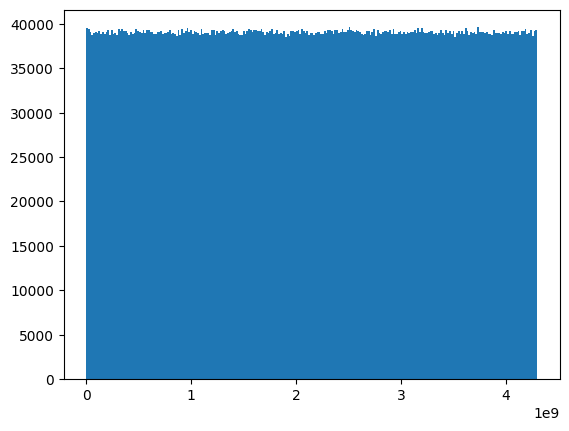

In [8]:
def lcg_drand48(seed):
    """drand48 1983 LCG generator"""
    while True:
        # wrap int around to have max 48 bits
        seed = (seed * 252149039917 + 11) & (2**48 - 1)
        # don't output the seed but a function on it
        yield seed >> 16

# seed generator with val: 1 and print first 100 values
drand48 = lcg_drand48(1)

# plot the number of time we get each number of the first 100 values
plt.hist([next(drand48) for x in range(0, 10000000)], bins = 256)
plt.show()

In the drand48 LCG we don't just get the next number in the sequence, here we shifts all the bits 16 places to the right with the right-most 16-bits getting dropped as a result.

Exemple of bit shift:
    if we have `1017 >> 3`, 1017 is 11 1111 1001 in binary and with the shift we end up with 111 1111 which is 127

The bit shift operations helps up to have a 16-bit generator with a 8-bit output

## PCG (Permuted Congruential Generator)

In Numpy 1.17, the notion of PCGs was introduced with an algorithm called Mersenne Twister, specifically the MT19937 variant. This is a 32-bit generator with a 32-bit output.

The idea behind PCG is:
- outputting a function of the state, rather than the state directly, seems to increase randomness
- LCGs clearly lack randomness in the lower bits (top left chart), but the higher bits tend to be ‘more random’ (bottom right chart)
- if we have e.g. a 16-bit state outputting an 8-bit number, then we only need to choose 8 bits to output
- why don’t we use the top few bits of the 16-bit state, which are the most random, to choose which function we apply to the remainder of the 16-bit state to generate the 8-bit output
- in other words, let’s use the most random part of our state to randomly select a transform function to apply to the rest of the state — a randomised algorithm of sorts

PCGs family, have different transformation:
- Bit shift
- Bit rotation
- Bit xorshift

These transformations are used and combined to create multiple PCGs, like the PCG XSH-RS (xorshift, random shift) and the PCG XSL-RR (xorshift, random rotation) which is used in Numpy specificialy PCG XSL RR 128/64.

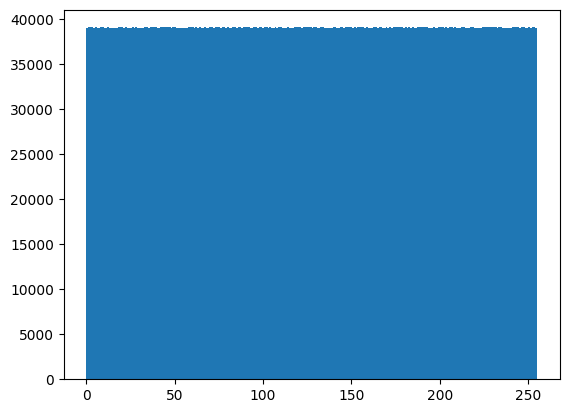

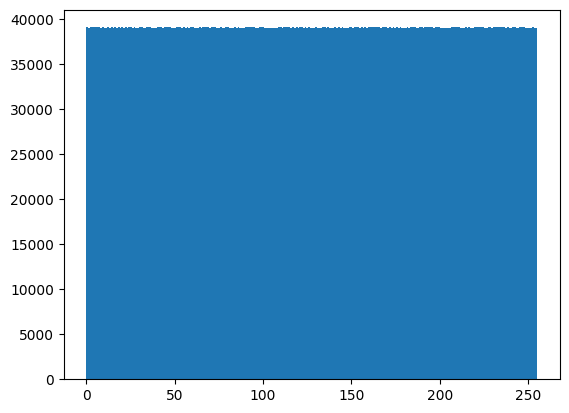

In [10]:
m = 2**16
a = 4 * 4321 + 1
c = 8671
s = 5423

def rotr(x, r, b):
    """
    Rotates bits in a b bit integer, x, right by r places
    e.g. if we pass x = 30 and r = 2 then we have
    bin(x) = 11110 so rotr(30, 2) = 10111
    i.e. shift everything to the right
    """
    # checker to ensure rotation is within bit size
    if r == b:
        return x
    elif r > b:
        r = r % b
    # make input have b bits, then shift to right
    # this will form our lower/bottom bits of new number
    bottom = (x & (2**b - 1)) >> r
    # shift knocked off bits to top (left-side)
    top = x << (b - r)
    top = top & (2**b - 1)
    # put together
    return top | bottom


def xor_rr(x, r, b):
    """Conducts a bitwise xor then rotate on b-bit length integer x"""
    # take the top r bits to define our rotation
    c = x >> (b*2 - r)
    # bitwise shift the others by 6 and take xor
    x ^= x >> ((b*2 - (-r) - (b - r)) // 2)
    # rotate and return
    return rotr(x, c, 8)


def xor_rs(x, r, b):
    """Conducts a bitwise xor then shift on b-bit length integer x"""
    # take the top r bits to define our shift
    c = x >> (b*2 - r)
    # bitwise shift the others by 6 and take xor
    x ^= x >> ((b*2 - (-r) - (b - r)) // 2)
    # shift and return
    return (x >> (8 - 2 - c)) & (2**8 - 1)


def pcg_xor_rr_16(m, a, c, r, s):
    """16 bit PCG-XOR-RR generator with 8-bit output"""
    while True:
        # compute state
        s = (a * s + c) % m
        # manipulate state to output
        yield xor_rr(s, r, 8)


def pcg_xor_rs_16(m, a, c, r, s):
    """16 bit PCG-XOR-RS generator with 8-bit output"""
    while True:
        # compute state
        s = (a * s + c) % m
        # manipulate state to output
        yield xor_rs(s, r, 8)

pcg_xor_rs = pcg_xor_rs_16(m, a , c, 2, s)
pcg_xor_rr = pcg_xor_rr_16(m, a , c, 2, s)

# plot the number of time we get each number of the first 100 values
plt.hist([next(pcg_xor_rs) for x in range(0, 10000000)], bins = 256)
plt.show()

# plot the number of time we get each number of the first 100 values
plt.hist([next(pcg_xor_rr) for x in range(0, 10000000)], bins = 256)
plt.show()